# Séance 2 - Réseau convolutionnel

Dans cette séance nous travaillerons avec le dataset d'image FashionMNIST. Il correspond à des images de vêtements. Notre objectif est de construire un réseau de neurones convolutionnel capable d'identifier le type de vêtement.

Commençons par importer quelques librairies qui nous serons utile pour la suite:
* **Numpy** : Calcul matriciel
* **Pandas** : Travail avec des DataFrame
* **Matplotlib** : Graphiques, et on utilise également la sur-couche **seaborn**
* **Tensorflow** : librairie qui permet la définition de réseau de neurones, et une *interface* plus simple d'utilisation **Keras**

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

Importons les données et créons immédiatement trois jeu de données:
* **Train** : dataset qui sert d'entraînement à l'algorithme
* **Validation** : dataset qui permettra à l'algorithme de mesurer sa performance sur un jeu différent du *train*
* **Test** : dataset non vu lors de l'entraînement pour contrôler la performance de l'algorithme

Par définition du dataset, le jeu de test est composée de 10000 images et le jeu d'entraînement et de validation c'est 60000. Nous allons dédier 80% au jeu d'entraînement et 20% pour la validation.

In [2]:
from sklearn.model_selection import train_test_split

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (fashion_mnist.load_data())
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

Regardons les dimensions des trois datasets :

In [3]:
for (dataset, name) in zip([X_train, X_valid, X_test], ["Train", "Validation", "Test"]):
  print(name, ":", dataset.shape)

Train : (48000, 28, 28)
Validation : (12000, 28, 28)
Test : (10000, 28, 28)


Les classes sont encore des nombres, mais ils correspondent à une catégorie. Pour mieux visualiser, nous allons faire un dictionnaire.

In [4]:
label_map = {0: "t-shirt/top", 1: "trouser", 2: "pullover",
             3: "dress", 4: "coat", 5: "sandal",
             6: "shirt", 7: "sneaker", 8: "bag", 9: "ankle boot"}

Visualisons quelques exemples d'images du dataset d'entraînement:

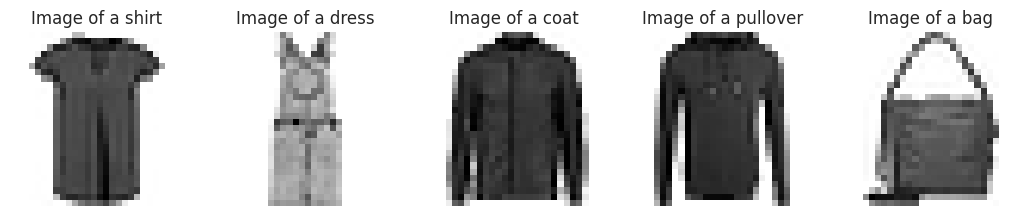

In [5]:
n = 5

plt.figure(figsize=(13, 6))
for plot_index in range(1, n+1):
  plt.subplot(1, n, plot_index)
  index = np.random.randint(low=0, high=len(X_train))
  plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
  plt.title("Image of a %s" % label_map[y_train[index]])
  plt.axis('off')
plt.show()

Il ne nous reste plus qu'à décrire le réseau de neurones.

## Mon premier réseau de neurone convolutionnel

On veut définir le réseau suivant:
* Deux convolutions avec 32 filtres 3x3 en conservant la taille (avec du padding donc)
* Une couche max pooling avec un filtre 2x2 et 2 de stride
* Une couche Flatten puis un réseau dense de 64 neurones
* Une couche de sortie à 10 neurones

In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal", input_shape=[28, 28, 1]),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
])

Pour s'assurer que l'on a bien compris comment fonctionnait chaque couche, comptons le nombre de paramètres:
* Couche de convolution de 32 filtres 3x3 : 32 * (3x3x1 + 1) = 320, image de taille 28x28x32
* Couche de convolution de 32 filtres 3x3 : 32 * (3x3x32 + 1) = 9248, image de taille 28x28x32
* Couche de pooling : aucun paramètre, mais une taille de 14x14x32
* Couche dense de 128 neurones : 128 * (14x14x32 + 1) = 802944
* Couche dense de 10 neurones : 10 * (128 + 1) = 1290

Soit au total un réseau de neurones avec 813802 paramètres.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               802944    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

Avant de lancer l'entraînement, n'oublions pas de normaliser les données !

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

Nous pouvons à présent lancer l'entraînement.

In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.01), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1500/1500 [==============================] - 17s 9ms/step - loss: 0.4591 - accuracy: 0.8405 - val_loss: 0.3473 - val_accuracy: 0.8779
Epoch 2/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3108 - accuracy: 0.8889 - val_loss: 0.3015 - val_accuracy: 0.8928
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2644 - accuracy: 0.9035 - val_loss: 0.2870 - val_accuracy: 0.8977
Epoch 4/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2322 - accuracy: 0.9153 - val_loss: 0.2811 - val_accuracy: 0.8976
Epoch 5/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2079 - accuracy: 0.9234 - val_loss: 0.2814 - val_accuracy: 0.8997
Epoch 6/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1874 - accuracy: 0.9316 - val_loss: 0.2635 - val_accuracy: 0.9084
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1685 - accuracy: 0.9384 - val_loss: 0.2609 - val_accuracy

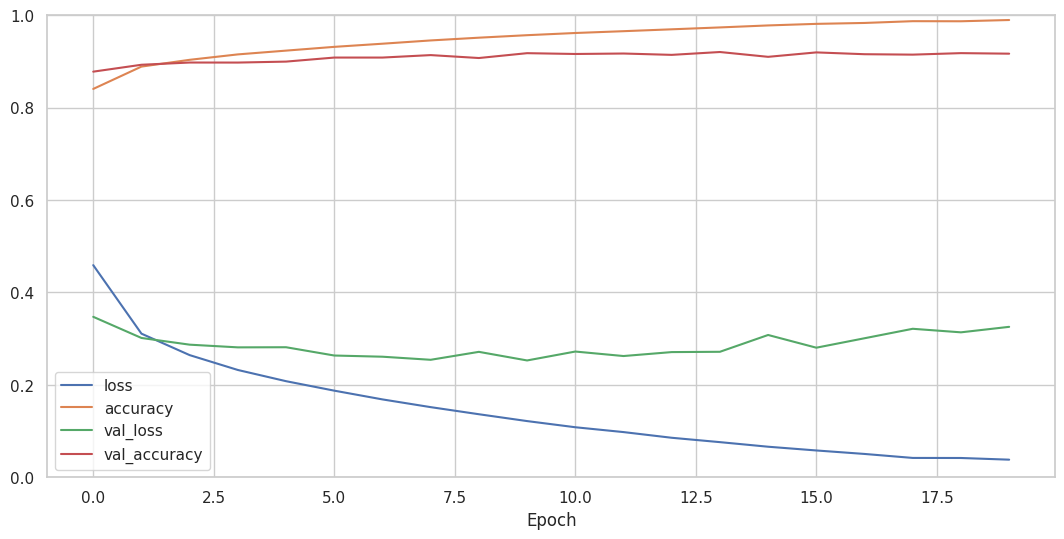

In [10]:
def plot_learning_curves(history, figsize=(13, 6)):
    historic = pd.DataFrame(history.history)
    historic.plot(figsize=figsize)

    plt.xlabel("Epoch")
    plt.ylim(0, 1)
    plt.show()

historic = pd.DataFrame(history.history)
plot_learning_curves(history)

Il va clairment falloir faire mieux.

## A vous de jouer !

Maintenant que l'on a vu comment définir un réseau de neurones convolutionnel et l'entraîner, c'est à vous de traiter au moins un des sujets proposés.